In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

# load data from file
df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


<AxesSubplot: >

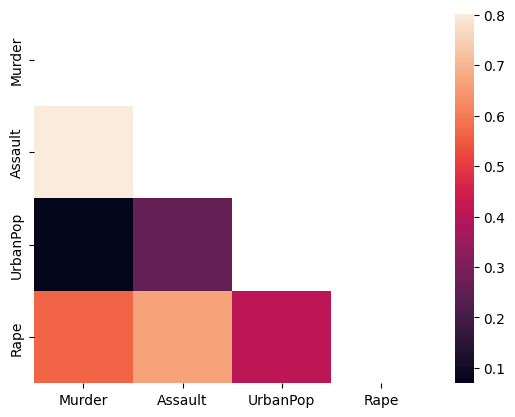

In [2]:
# show correlations between features using heatmap
corr_df = df.corr(numeric_only=True)
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut)

Most of the features have positive correlations between each other especially 'murder & assault'. However, there is no correlation between 'murder & urbanpop'.

In [3]:
# Prepare data ans store columns name and cities into variables
X = df.iloc[:,0:4]
labels = X.columns
cities = df.index

# Standardize the features before applying PCA
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X)
X = scalar.transform(X)

Apply PCA with n_components=4 and display cumulative sum of variance ratio

In [4]:
from sklearn.decomposition import PCA
X_train = X
pca_model = PCA(n_components=4)
x_pca = pca_model.fit_transform(X_train)
print(pca_model.explained_variance_ratio_.cumsum())

[0.62006039 0.86750168 0.95664248 1.        ]


The first three principle components cover more than 95% of the data. Use n_components=3 for the pca_model

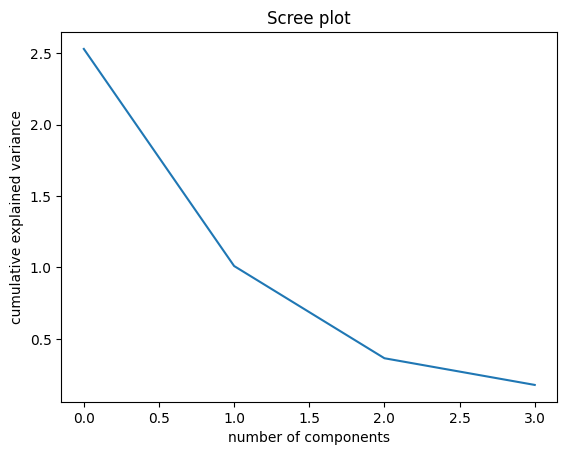

In [5]:
plt.plot(pca_model.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The scree plot also shows that the first three components should be used for the pca_model

In [6]:
pca_model = PCA(n_components=3)
x_pca = pca_model.fit_transform(X)

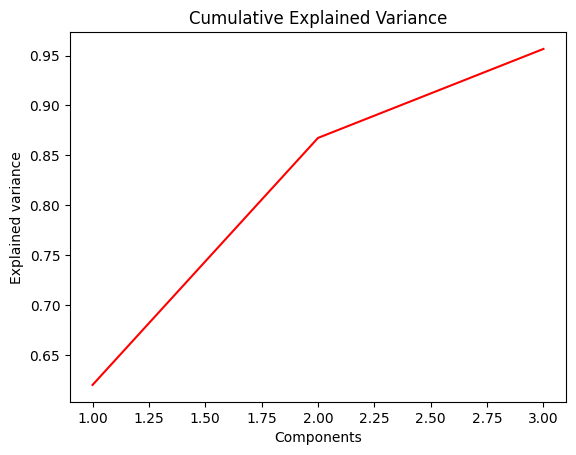

In [7]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.title("Cumulative Explained Variance")
plt.plot(range(1,len(pca_model.explained_variance_ratio_ )+1),
         np.cumsum(pca_model.explained_variance_ratio_),
         c='red')
plt.show()

Most of the features are explained and encompassed by PC1

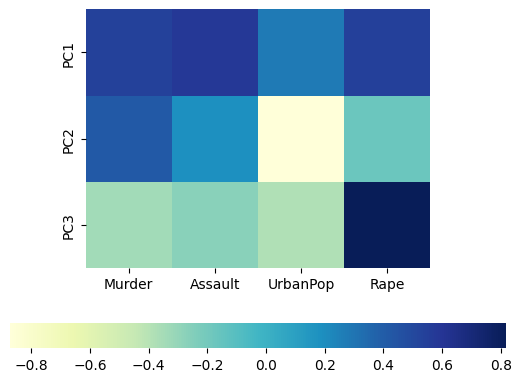

In [8]:
ax = sns.heatmap(pca_model.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PC"+str(x) for x in range(1,pca_model.n_components_+1)],
                 xticklabels=labels,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

'Murder', 'Assault' and 'Rape' are the most important for PC1. 'UrbanPop' is the most important for PC2. 'Rape' is the most important for PC3

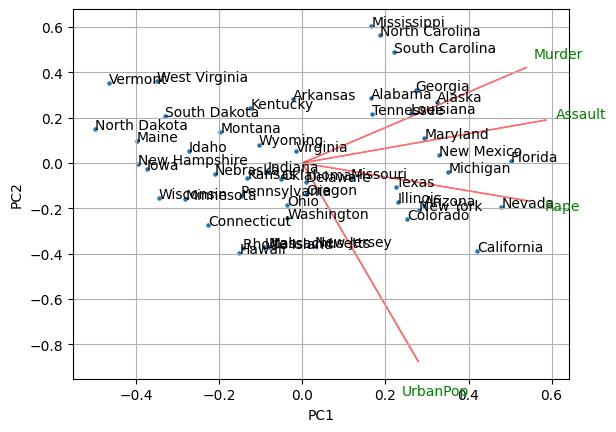

In [9]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

biplot(x_pca[:,0:2],np.transpose(pca_model.components_[0:2, :]),labels,cities)
plt.show()

The magnitude of the values in the eigenvectors of each feature is quite the same. It verifies 'Murder', 'Assault' and 'Rape' are important to PC1 while 'UrbanPop' is important to PC2.

In [10]:
pca_df = pd.DataFrame(x_pca, index = df.index)
pca_df.columns = ['PC1', 'PC2', 'PC3']
pca_df.head()

,PC1,PC2,PC3
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


## Hierarchical clustering

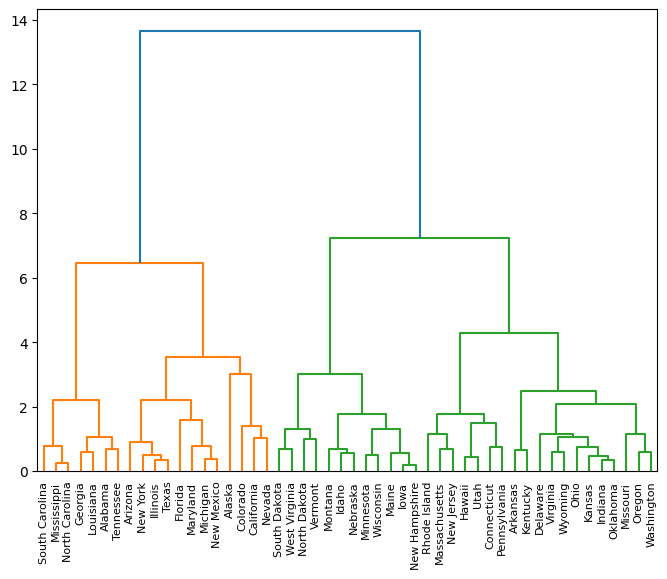

In [11]:
# Use dendrogram to determine the number of clusters
from scipy.cluster import hierarchy

clusters = hierarchy.linkage(pca_df, method="ward")
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters, labels=pca_df.index)

The dendrogram shows that AgglomerativeClustering should use n_clusters=2

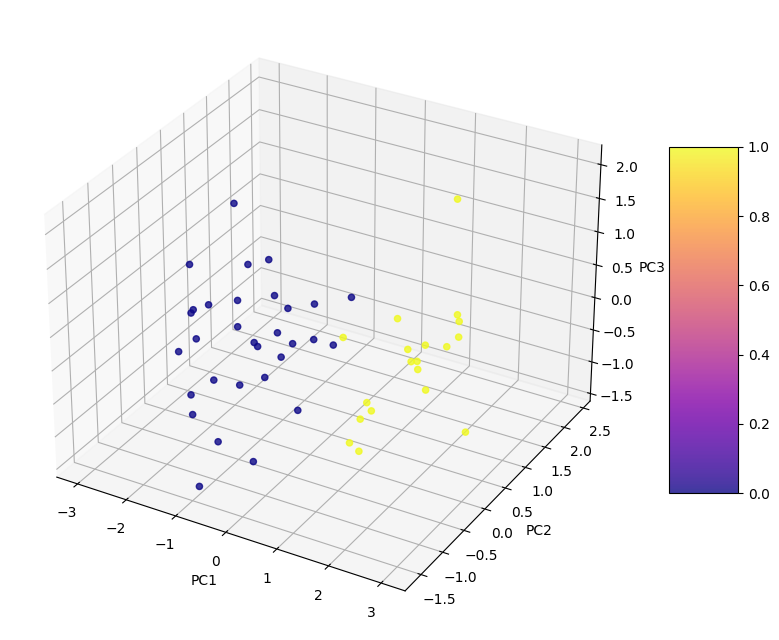

In [12]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(pca_df)

# Creating figure
fig = plt.figure(figsize = (10, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
my_cmap = plt.get_cmap('plasma')
sctt = ax.scatter3D(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=labels, alpha = 0.8, cmap = my_cmap)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

## K-means clustering

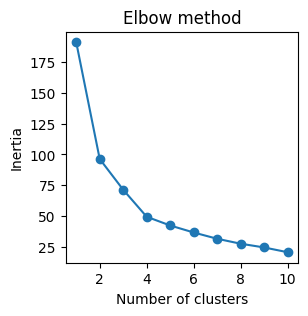

In [13]:
# Use elbow method to determine n_clusters for KMeans
from sklearn.cluster import KMeans

inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(3,3))
plt.plot(range(1,11), inertia, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

KMeans will use n_clusters=2

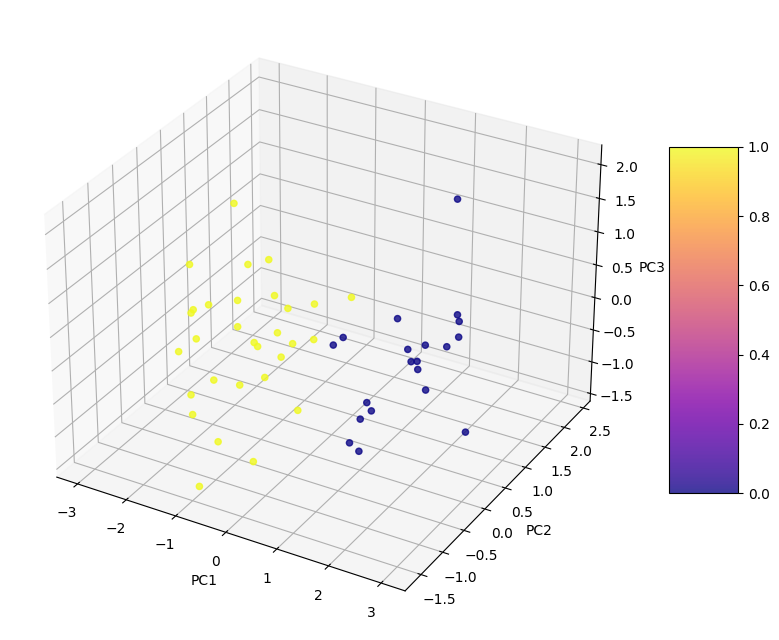

In [14]:
kmeans = KMeans(n_clusters=2)
labels  = kmeans.fit_predict(pca_df)

# Creating figure
fig = plt.figure(figsize = (10, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
my_cmap = plt.get_cmap('plasma')
sctt = ax.scatter3D(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=labels, alpha = 0.8, cmap = my_cmap)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

In [15]:
from sklearn.metrics import silhouette_score
print("Silhouette score")
print('AgglomerativeClustering:\t',silhouette_score(pca_df, hierarchical_cluster.fit_predict(pca_df)))
print('KMeans:\t\t\t\t', silhouette_score(pca_df, kmeans.fit_predict(pca_df)))

Silhouette score
AgglomerativeClustering:	 0.4265110406142638
KMeans:				 0.4307515152399549


AgglomerativeClustering and KMeans produce the same clusterings.

However, KMeasn is slightly better than Agglomerative according to their silhouette scores.